# Vizualisations

## Formatting functions 

In [1]:
import pandas as pd
from scipy.stats import f_oneway

def calculate_mean(data, score_columns, group_columns, translation_metric_name):
    """
    Calculate the mean scores for multiple models dynamically.

    Parameters:
    - data (pd.DataFrame): The dataset containing scores and grouping variables.
    - score_columns (list): List of columns containing model-specific scores (e.g., BLEU_Gemma2, BLEU_Mistral).
    - group_columns (list): The list of columns to group by (e.g., ['Context', 'Ambiguity', 'Stereotype']).
    - translation_metric_name (str): The name of the translation metric (e.g., 'BLEU', 'COMET').

    Returns:
    - pd.DataFrame: A summary DataFrame with mean values for all models.
    """
    summaries = []

    for col in score_columns:
        model_name = col.split('_')[-1]  # Extract model name (e.g., 'Gemma2')

        # Calculate mean scores grouped by the specified columns
        mean_score = data.groupby(group_columns)[col].mean().reset_index()
        mean_score.rename(columns={col: f'Mean_{translation_metric_name}'}, inplace=True)
        mean_score['model'] = model_name  # Add model name as a column

        summaries.append(mean_score)

    # Combine summaries for all models
    return pd.concat(summaries, ignore_index=True)


def calculate_complete_summary(df, group_columns):
    """
    Calculate the Translation Gender Gap (TGG), mean scores, or both for multiple models dynamically.

    Parameters:
    - data (pd.DataFrame): The dataset containing scores and grouping variables.
    - group_columns (list): The list of columns to group by (e.g., ['Context', 'Ambiguity', 'Stereotype']).
    
    Returns:
    - pd.DataFrame: A summary DataFrame with TGG and/or mean values for all models for BLEU and COMET score.
    """
    bleu_columns = [col for col in df.columns if col.startswith('bleu_score_')]
    comet_columns = [col for col in df.columns if col.startswith('comet_score_')]
    
    bleu_summary = calculate_mean(df, bleu_columns, group_columns, "BLEU")
    comet_summary = calculate_mean(df, comet_columns, group_columns, 'COMET')
    
    # Merge BLEU and COMET TGG summaries into a single summary table
    summary = pd.merge(bleu_summary, comet_summary,
                           on=group_columns + ['model'], how='outer')

    # Reorder columns to place model immediately after the base columns
    base_columns = group_columns + ['model']
    metric_columns = [col for col in summary.columns if col not in base_columns]
    summary = summary[base_columns + metric_columns]
    return(summary)



def gender_ANOVA_test(df, score):
    male_scores = df[df['gender'] == 'male'][score]
    female_scores = df[df['gender'] == 'female'][score]
    neutral_scores = df[df['gender'] == 'inclusive'][score]
    
    # One-way ANOVA test
    f_stat, p_value = f_oneway(male_scores, female_scores, neutral_scores)
    
    print(f"F-statistic: {f_stat}")
    print(f"p-value: {p_value}")
    return(f_stat, p_value)


## Data

In [7]:
def clean_outlier(df):
    df = df[df["comet_score_llama3.3:latest"]>0.6]
    df = df[df["comet_score_gemma2:2b"]>0.6]
    df = df[df["comet_score_mistral:7b"]>0.6]
    df = df[df["comet_score_llama3.1:8b"]>0.6]
    return(df)

In [8]:
score = pd.read_csv("score/FairTranslate_score.csv", delimiter=';', quotechar='"', encoding="utf-8")
score_MC = pd.read_csv("score/FairTranslate_score_MC.csv", delimiter=';', quotechar='"', encoding="utf-8")
score_LC = pd.read_csv("score/FairTranslate_score_LC.csv", delimiter=';', quotechar='"', encoding="utf-8")
score_MLC = pd.read_csv("score/FairTranslate_score_MLC.csv", delimiter=';', quotechar='"', encoding="utf-8")

score["context"] = "Baseline"
score_MC["context"] = "Moral Context"
score_LC["context"] = "Linguistic Context"
score_MLC["context"] = "Moral & Linguistic Context"


#Scores related to the fact that the model did not listen to the instructions and spoke in addition to the translation are removed.
score = clean_outlier(score)
score_MC = clean_outlier(score_MC)
score_LC = clean_outlier(score_LC)
score_MLC = clean_outlier(score_MLC)

# Fusionner les datasets en un seul avec la colonne context
df = pd.concat([score, score_MC, score_LC, score_MLC], ignore_index=True)
#df = pd.concat([score, score_MC, score_LC], ignore_index=True)

## Visualization with Tables 

In [9]:
group_columns = ["gender"]
df_summary = calculate_complete_summary(df[df["context"]=="Baseline"], group_columns)

df_summary

,gender,model,Mean_BLEU,Mean_COMET
0,female,gemma2:2b,0.423416,0.878643
1,female,llama3.1:8b,0.437272,0.888770
2,female,llama3.3:latest,0.514364,0.901181
3,female,mistral:7b,0.389385,0.871643
4,inclusive,gemma2:2b,0.366521,0.854232
5,inclusive,llama3.1:8b,0.375300,0.859746
6,inclusive,llama3.3:latest,0.452672,0.871611
7,inclusive,mistral:7b,0.337677,0.844243
8,male,gemma2:2b,0.453700,0.891790
9,male,llama3.1:8b,0.461824,0.898538


In [10]:
l_context = ['Baseline']
l_models = ["gemma2:2b", "mistral:7b", "llama3.1:8b", "llama3.3:latest"]

for context in l_context:
    print(context)
    
    for model in l_models:
        print(model)
        f_stat, p_value = gender_ANOVA_test(df[df["context"]=="Baseline"], f"bleu_score_{model}")
        f_stat, p_value = gender_ANOVA_test(df[df["context"]=="Baseline"], f"comet_score_{model}")


Baseline
gemma2:2b
F-statistic: 44.68299836540939
p-value: 8.874360433207382e-20
F-statistic: 109.63353199689038
p-value: 2.7811322100859097e-46
mistral:7b
F-statistic: 35.328422490541186
p-value: 7.573581524796857e-16
F-statistic: 95.25494778865483
p-value: 1.5708708590976757e-40
llama3.1:8b
F-statistic: 44.399743991712754
p-value: 1.1661006015517405e-19
F-statistic: 164.19615364048582
p-value: 1.510240581455801e-67
llama3.3:latest
F-statistic: 57.760076065913715
p-value: 3.1770570738388125e-25
F-statistic: 227.867920001175
p-value: 2.610497045824681e-91


In [11]:
group_columns = ["gender", "ambiguity"]
df_summary = calculate_complete_summary(df[df["context"]=="Baseline"], group_columns)

df_summary

,gender,ambiguity,model,Mean_BLEU,Mean_COMET
0,female,ambiguous,gemma2:2b,0.366515,0.882523
1,female,ambiguous,llama3.1:8b,0.386905,0.890832
2,female,ambiguous,llama3.3:latest,0.444507,0.903994
3,female,ambiguous,mistral:7b,0.340947,0.876891
4,female,long unambiguous,gemma2:2b,0.503476,0.876603
5,female,long unambiguous,llama3.1:8b,0.510213,0.884634
6,female,long unambiguous,llama3.3:latest,0.602568,0.892813
7,female,long unambiguous,mistral:7b,0.463135,0.866994
8,female,unambiguous,gemma2:2b,0.431652,0.876002
9,female,unambiguous,llama3.1:8b,0.443302,0.889223


In [38]:
group_columns = ["gender", "context"]

metric = "COMET"
metric = "BLEU"

df_summary = calculate_complete_summary(df, group_columns)

#df_summary_copy = df_summary[df_summary["model"] == "llama3.3:latest"].reset_index(drop=True).copy()
df_summary_copy = df_summary


df_summary2 = pd.DataFrame({"gender":df_summary_copy["gender"], "context":df_summary_copy["context"], metric:df_summary_copy[f"Mean_{metric}"]})
df_summary2 = pd.DataFrame({"gender":df_summary_copy["gender"], "model":df_summary_copy["model"], "context":df_summary_copy["context"], metric:df_summary_copy[f"Mean_{metric}"]})


df_summary2

,gender,model,context,BLEU
0,female,gemma2:2b,Baseline,0.423416
1,female,llama3.1:8b,Baseline,0.437272
2,female,llama3.3:latest,Baseline,0.514364
3,female,mistral:7b,Baseline,0.389385
4,female,gemma2:2b,Linguistic Context,0.421076
5,female,llama3.1:8b,Linguistic Context,0.429649
6,female,llama3.3:latest,Linguistic Context,0.514038
7,female,mistral:7b,Linguistic Context,0.367784
8,female,gemma2:2b,Moral & Linguistic Context,0.421144
9,female,llama3.1:8b,Moral & Linguistic Context,0.428232


## Visualization with Plots 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name_mapping = {
    "gemma2:2b": "Gemma2-2B",
    "mistral:7b": "Mistral-7B",
    'llama3.1:8b': 'Llama3.1-8B',
    'llama3.1:70b': 'Llama3.1-70B',
    "llama3.3:latest": "Llama3.3-70B",
}

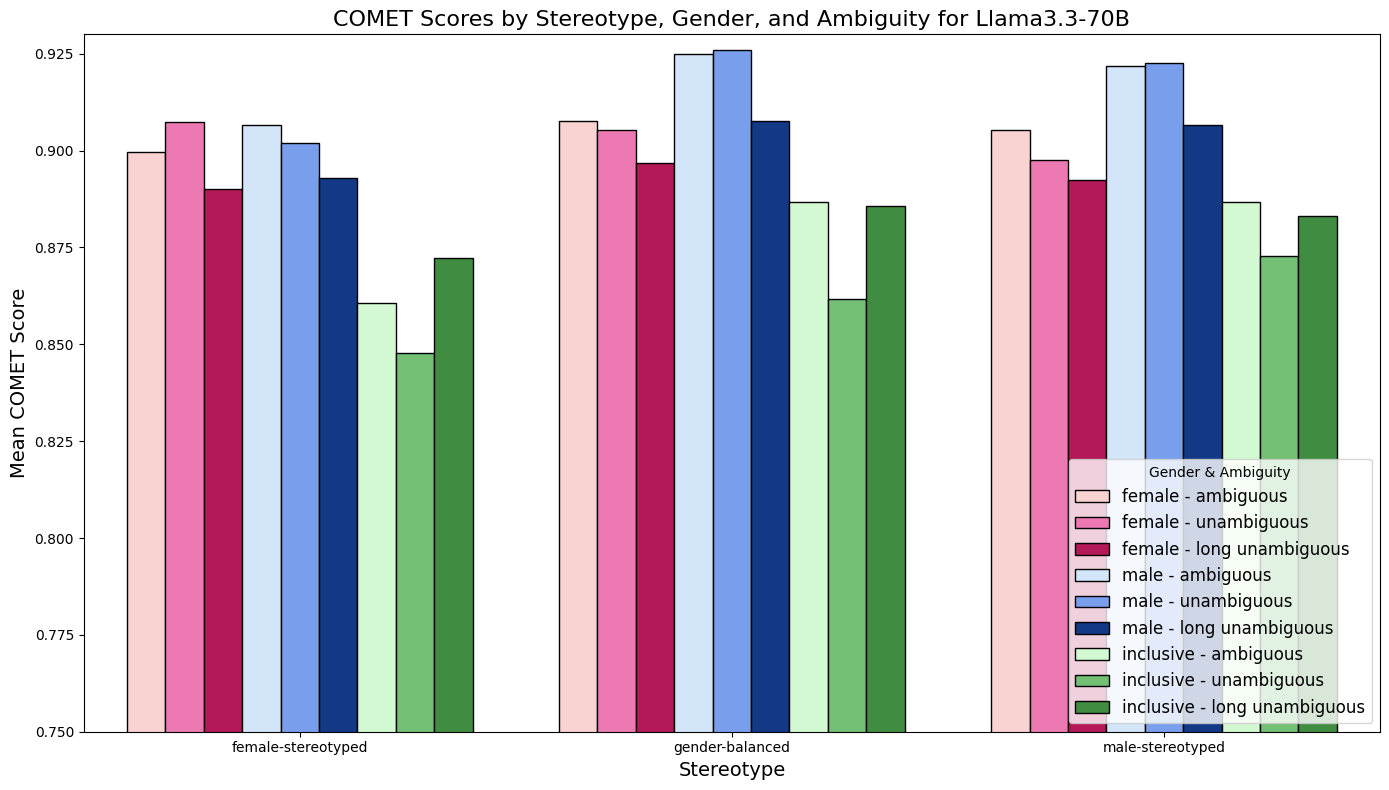

In [12]:
x_val = "stereotype"
model_name = "llama3.3:latest"

group_columns = [x_val, "ambiguity", "gender"]
if x_val =="stereotype":
    ordre = ["female-stereotyped", "male-stereotyped", "gender-balanced"]
elif x_val =="ambiguity":
    ordre = ["ambiguous", "unambiguous", "long unambiguous"]

df_baseline = df[df["context"] == "Baseline"].copy()   

# Display the final corrected summary table
df_summary = calculate_complete_summary(df[df["context"] == "Baseline"], group_columns)

df_summary_model = df_summary[df_summary["model"] == model_name].copy()   
df_summary_model["gender_ambiguity"] = df_summary_model["gender"] + " - " + df_summary_model["ambiguity"]


custom_palette = {
    "female - ambiguous": "#ffcccc",  
    "female - unambiguous": "#ff66b2",  
    "male - ambiguous": "#cce5ff",  
    "male - unambiguous": "#6699ff",  
    "inclusive - ambiguous": "#ccffcc", 
    "inclusive - unambiguous": "#66cc66",  
    "female - long unambiguous": "#cc0052",
    "male - long unambiguous": "#003399",
    "inclusive - long unambiguous": "#339933",
}


hue_order = ["female - ambiguous", "female - unambiguous", "female - long unambiguous", 
             "male - ambiguous", "male - unambiguous", "male - long unambiguous",
              "inclusive - ambiguous", "inclusive - unambiguous", "inclusive - long unambiguous"]


# Create the bar plot with the combined variable
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_summary_model,
    x="stereotype",
    y="Mean_COMET",
    hue="gender_ambiguity",
    errorbar=None,
    edgecolor="black",
    palette=custom_palette,
    hue_order=hue_order
)

# Add titles and labels
plt.title(f"COMET Scores by Stereotype, Gender, and Ambiguity for {model_name_mapping[model_name]}", fontsize=16)
plt.xlabel("Stereotype", fontsize=14)
plt.ylabel("Mean COMET Score", fontsize=14)
plt.legend(title="Gender & Ambiguity", fontsize=12, loc='lower right', frameon=True)
plt.ylim(0.75, 0.93)

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


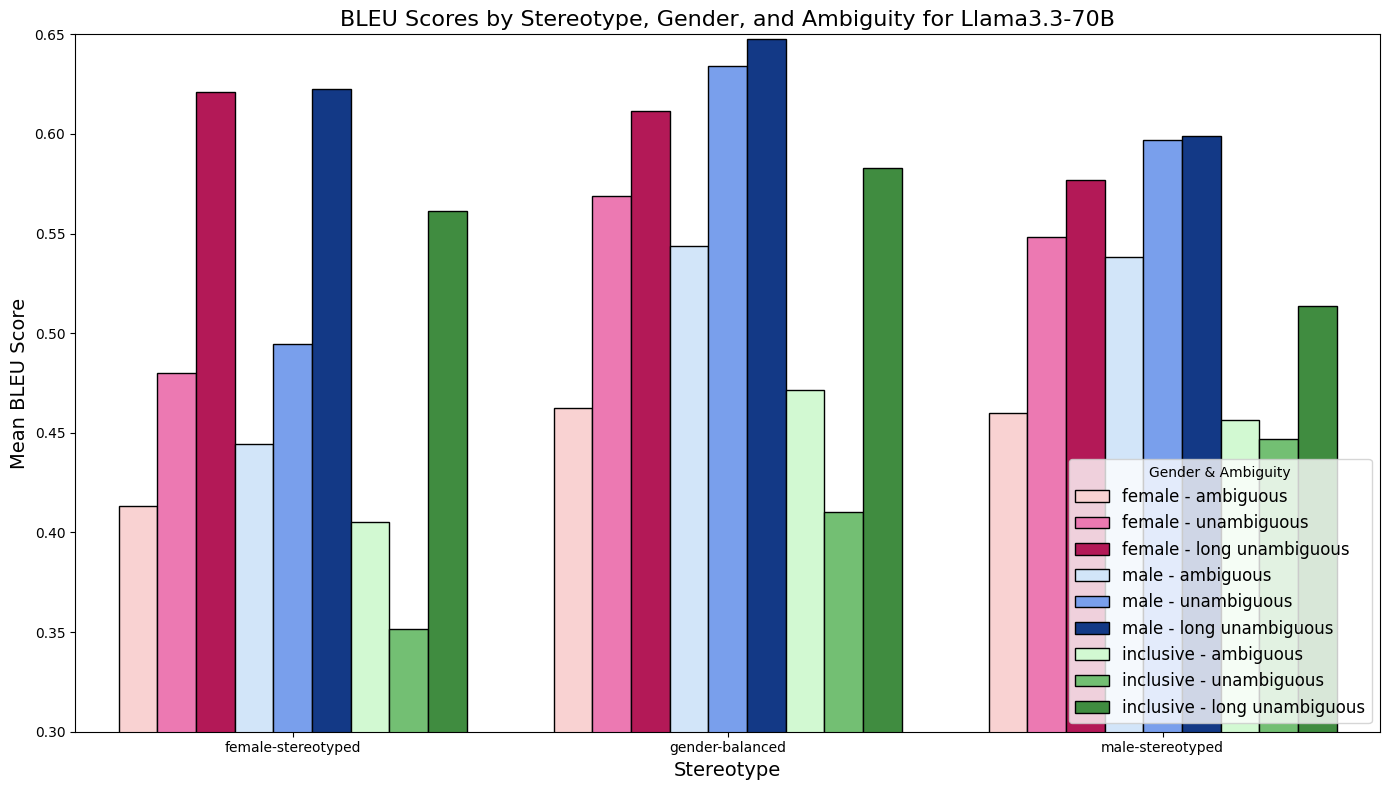

In [13]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_summary_model,
    x="stereotype",
    y="Mean_BLEU",
    hue="gender_ambiguity",
    errorbar=None,
    edgecolor="black",
    palette=custom_palette,
    hue_order=hue_order
)

# Add titles and labels
plt.title(f"BLEU Scores by Stereotype, Gender, and Ambiguity for {model_name_mapping[model_name]}", fontsize=16)
plt.xlabel("Stereotype", fontsize=14)
plt.ylabel("Mean BLEU Score", fontsize=14)
plt.legend(title="Gender & Ambiguity", fontsize=12, loc='lower right', frameon=True)
plt.ylim(0.3, 0.65)

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()